# Variational Autoencoder (VAE) On MNIST hand-written digits dataset

## Load & Binarize MNIST
We’ll binarize using a threshold (pixel > 0.5 → 1 else 0), which is standard for MNIST + VAE.

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, Model
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Load MNIST
(x_train, _), (x_test, _) = tf.keras.datasets.mnist.load_data()

In [3]:
# Normalize to pixels [0, 1]
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0

In [4]:
# Binarize pixels: 0 or 1
x_train_bin  = np.where(x_train > 0.5, 1.0, 0.0)
x_test_bin = np.where(x_test > 0.5, 1.0, 0.0)

In [5]:
# Flatten images
x_train_bin = x_train.reshape(-1, 28 * 28)
x_test_bin = x_test.reshape(-1, 28 * 28)

In [6]:
print("x_train_bin shape:", x_train_bin.shape)
print("x_test_bin shape:", x_test_bin.shape)
print("Example binarized image:\n", x_train_bin[0].reshape(28,28))

x_train_bin shape: (60000, 784)
x_test_bin shape: (10000, 784)
Example binarized image:
 [[0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.  

## VAE Model (Encoder + Decoder)

### Encoder

In [7]:
latent_dim = 2  # can change this, small for visualization

# Encoder
class Encoder(Model):
    def __init__(self, latent_dim):
        super(Encoder, self).__init__()
        # Two hidden layers
        self.dense1 = layers.Dense(512, activation='relu')
        self.dense2 = layers.Dense(256, activation='relu')
        # Latent variables
        self.mu = layers.Dense(latent_dim)        # mean of latent z
        self.log_var = layers.Dense(latent_dim)   # log variance of latent z

    def call(self, x):
        h = self.dense1(x)
        h = self.dense2(h)
        mu = self.mu(h)
        log_var = self.log_var(h)
        return mu, log_var

### Sampling Layer (Reparameterization Trick)

In [8]:
def sample_z(mu, log_var):
    epsilon = tf.random.normal(shape=tf.shape(mu))
    z = mu + tf.exp(0.5 * log_var) * epsilon
    return z

In [9]:
# Test encoder
encoder = Encoder(latent_dim)
sample_input = tf.convert_to_tensor(x_train_bin[:10])  # batch of 10
mu, log_var = encoder(sample_input)
z = sample_z(mu, log_var)

In [10]:
print("mu shape:", mu.shape)
print("log_var shape:", log_var.shape)
print("sample z shape:", z.shape)

mu shape: (10, 2)
log_var shape: (10, 2)
sample z shape: (10, 2)


### Decoder

In [11]:
class Decoder(Model):
    def __init__(self, latent_dim):
        super(Decoder, self).__init__()
        self.dense1 = layers.Dense(256, activation='relu')
        self.dense2 = layers.Dense(512, activation='relu')
        self.output_layer = layers.Dense(28*28, activation='sigmoid')  # outputs probabilities

    def call(self, z):
        h = self.dense1(z)
        h = self.dense2(h)
        x_hat = self.output_layer(h)
        return x_hat

In [12]:
# Test decoder
decoder = Decoder(latent_dim)
sample_recon = decoder(z)

In [13]:
print("Reconstructed shape:", sample_recon.shape)  # should be (batch_size, 784)
print("Sample reconstructed values (probabilities):\n", sample_recon[0][:10])

Reconstructed shape: (10, 784)
Sample reconstructed values (probabilities):
 tf.Tensor(
[0.51824784 0.50502914 0.512853   0.50241023 0.50365466 0.50538415
 0.51936406 0.49955204 0.5019656  0.5162298 ], shape=(10,), dtype=float32)


### VAE Loss & Model
VAE loss = Reconstruction loss + KL divergence

In [14]:
# Binary Cross-Entropy + KL Divergence
def vae_loss(x, x_hat, mu, log_var):
    # Reconstruction loss (binary cross-entropy per pixel)
    bce = tf.keras.losses.binary_crossentropy(x, x_hat, from_logits=False)
    bce = tf.reduce_sum(bce, axis=-1)  # sum over pixels

    # KL divergence between q(z|x) and p(z)
    kl = -0.5 * tf.reduce_sum(1 + log_var - tf.square(mu) - tf.exp(log_var), axis=1)

    # Return mean loss over batch
    return tf.reduce_mean(bce + kl)

### Train the VAE

In [15]:
# Optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

In [16]:
# Number of epochs and batch size
epochs = 20
batch_size = 128
dataset = tf.data.Dataset.from_tensor_slices(x_train_bin).shuffle(60000).batch(batch_size)

In [17]:
# Training loop
for epoch in range(epochs):
    total_loss = 0
    for step, x_batch in enumerate(dataset):
        with tf.GradientTape() as tape:
            mu, log_var = encoder(x_batch)
            z = sample_z(mu, log_var)
            x_hat = decoder(z)
            loss = vae_loss(x_batch, x_hat, mu, log_var)
        gradients = tape.gradient(loss, encoder.trainable_variables + decoder.trainable_variables)
        optimizer.apply_gradients(zip(gradients, encoder.trainable_variables + decoder.trainable_variables))
        total_loss += loss.numpy()
    
    print(f"Epoch {epoch+1}, Loss: {total_loss / (step+1):.2f}")

Epoch 1, Loss: 33.77
Epoch 2, Loss: 30.28
Epoch 3, Loss: 29.65
Epoch 4, Loss: 29.22
Epoch 5, Loss: 28.91
Epoch 6, Loss: 28.71
Epoch 7, Loss: 28.56
Epoch 8, Loss: 28.43
Epoch 9, Loss: 28.29
Epoch 10, Loss: 28.20
Epoch 11, Loss: 28.10
Epoch 12, Loss: 28.00
Epoch 13, Loss: 27.93
Epoch 14, Loss: 27.88
Epoch 15, Loss: 27.82
Epoch 16, Loss: 27.78
Epoch 17, Loss: 27.71
Epoch 18, Loss: 27.66
Epoch 19, Loss: 27.61
Epoch 20, Loss: 27.59


### Reconstruction

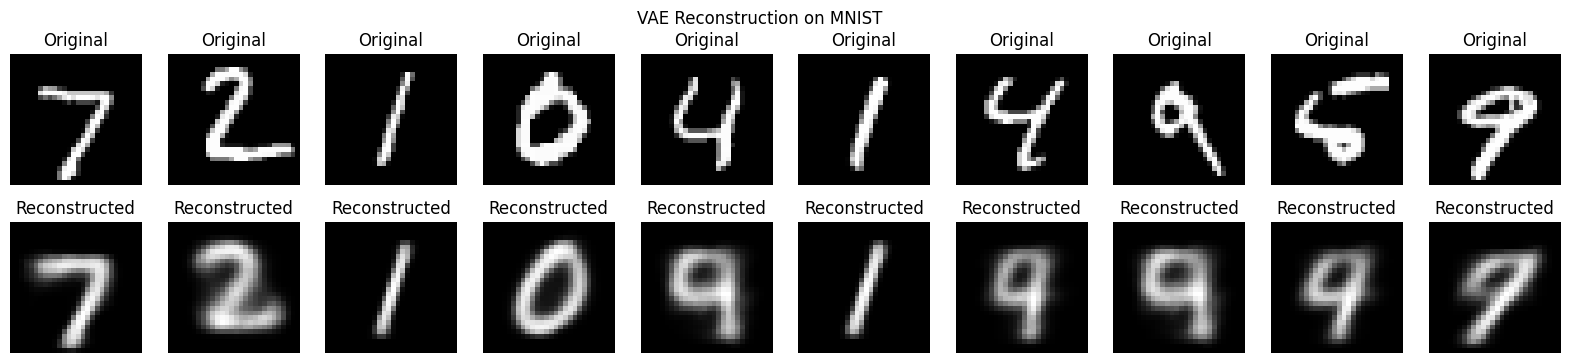

In [18]:
import matplotlib.pyplot as plt

# Select some test images (e.g., first 10)
num_images = 10
x_sample = x_test_bin[:num_images]

# Encode
mu, log_var = encoder(x_sample)
z = sample_z(mu, log_var)

# Decode
x_recon = decoder(z).numpy()

# Plot original vs reconstructed
plt.figure(figsize=(20,4))
for i in range(num_images):
    # Original
    plt.subplot(2, num_images, i+1)
    plt.imshow(x_sample[i].reshape(28,28), cmap='gray')
    plt.title("Original")
    plt.axis('off')
    
    # Reconstructed
    plt.subplot(2, num_images, i+1+num_images)
    plt.imshow(x_recon[i].reshape(28,28), cmap='gray')
    plt.title("Reconstructed")
    plt.axis('off')

plt.suptitle("VAE Reconstruction on MNIST")
plt.show()

### Visualize the latent space

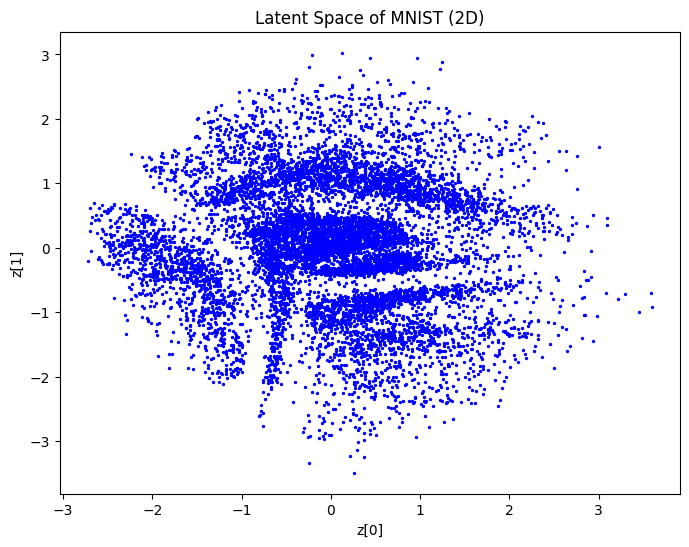

In [19]:
# Encode the test set
mu_test, log_var_test = encoder(x_test_bin)
z_test = sample_z(mu_test, log_var_test)

# For visualization, take just the means (mu) so it's smoother
z_test_mu = mu_test.numpy()

plt.figure(figsize=(8,6))
plt.scatter(z_test_mu[:,0], z_test_mu[:,1], s=2, c='blue')
plt.xlabel("z[0]")
plt.ylabel("z[1]")
plt.title("Latent Space of MNIST (2D)")
plt.show()

### Sample NEW digits

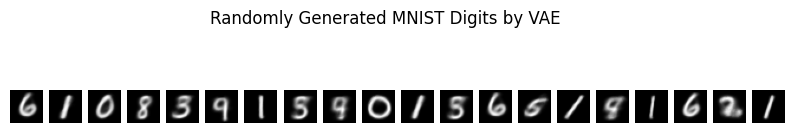

In [20]:
# Sample random points from standard normal
n_samples = 20
z_random = tf.random.normal(shape=(n_samples, latent_dim))

# Decode
x_generated = decoder(z_random).numpy()

# Plot generated digits
plt.figure(figsize=(10,2))
for i in range(n_samples):
    plt.subplot(1, n_samples, i+1)
    plt.imshow(x_generated[i].reshape(28,28), cmap='gray')
    plt.axis('off')
plt.suptitle("Randomly Generated MNIST Digits by VAE")
plt.show()